<a href="https://colab.research.google.com/github/Mnv31/Image-Caption-Generator/blob/main/Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Captionize: Image Caption Generator System**

In [ ]:
pip install nbstripout

In [ ]:
!pip install torch torchvision transformers Pillow matplotlib nltk

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving download (1).jpg to download (1) (1).jpg


In [ ]:
# List the uploaded files
print(uploaded)

{'download (1) (1).jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x08\x07\x06\t\x08\x07\x08\n\n\t\x0b\r\x16\x0f\r\x0c\x0c\r\x1b\x14\x15\x10\x16 \x1d"" \x1d\x1f\x1f$(4,$&1\'\x1f\x1f-=-157:::#+?D?8C49:7\x01\n\n\n\r\x0c\r\x1a\x0f\x0f\x1a7%\x1f%77777777777777777777777777777777777777777777777777\xff\xc0\x00\x11\x08\x00\x94\x01\x08\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x04\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x01\x04\x05\x02\x03\x07\x08\xff\xc4\x00A\x10\x00\x02\x01\x03\x03\x01\x06\x03\x05\x06\x04\x04\x07\x01\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1\x06\x13"AQa\x14q\x812\x91\xa1\xd1\xf0\x07#BR\xb1\xc1\x153r\xe1\x16$%\xf1CSbc\x82\x92\xc24\xff\xc4\x00\x1a\x01\x00\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\xff\xc4\x00*\x11\x00\x02\x02\x01\x04\x02\x02\x02\x01\x04\x03\x00\x00\x00\x00\x00\x01\x02\x00\x03\x11\x04\x12!1\x13A\x14"\x05Qa#2q\xc1\x81\

In [ ]:
from PIL import Image

# Get the image path from the uploaded files dictionary
image_path = list(uploaded.keys())[0]  # The first file you uploaded

# Open and display the image
image = Image.open(image_path)
image.show()  # This will open the image in a viewer

In [ ]:
import torchvision.transforms as transforms

# Define the image transform (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qv9ym4yd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qv9ym4yd
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=3c83ea93ad84e1487c4a8d89702e3ea369cc4b9678eb92369ca2a8e133a89111
  Stored in directory: /tmp/pip-ephem-wheel-cache-i1ph08a1/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [ ]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

print("CLIP model loaded successfully!")

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 45.9MiB/s]


CLIP model loaded successfully!


In [ ]:
# Load the CLIP model
model, preprocess = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Apply preprocessing to the image
image_tensor = preprocess(image).unsqueeze(0).to(device)

# Example of text descriptions to compare
text_inputs = torch.cat([clip.tokenize(f"a photo of {c}") for c in ["a cat", "a dog", "a person"]]).to(device)

# Get the image and text features
with torch.no_grad():
    image_features = model.encode_image(image_tensor)
    text_features = model.encode_text(text_inputs)

# Normalize the features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute similarity between image and text
similarities = (image_features @ text_features.T).squeeze(0)
values, indices = similarities.softmax(dim=-1).topk(3)

# Print the top 3 most similar descriptions
for value, index in zip(values, indices):
    print(f"Prediction: {['a cat', 'a dog', 'a person'][index]} with probability {value.item():.2f}")

Prediction: a person with probability 0.34
Prediction: a dog with probability 0.33
Prediction: a cat with probability 0.33


In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load the BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Generate the caption
out = model.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)
print("Generated Caption:", caption)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Generated Caption: sunflowers in the field


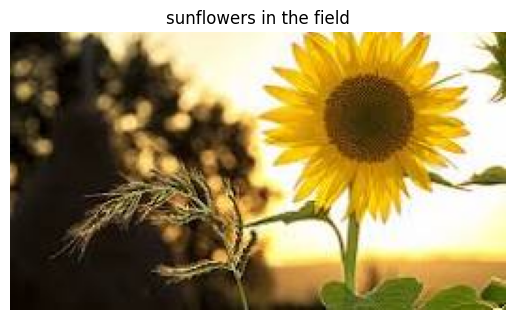

In [ ]:
import matplotlib.pyplot as plt

# Show the image with the caption
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title(caption)
plt.show()